In [0]:

# Importing necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, log1p
from pyspark.ml import Pipeline


# Loading the dataset into a DataFrame
df = spark.read.table("default.electric_vehicle_population_dataset_3_csv")


In [0]:

# Display basic information about the DataFrame
print("Data Schema:")
df.printSchema()


Data Schema:
root
 |-- VIN (1-10): string (nullable = true)
 |-- County: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Postal Code: integer (nullable = true)
 |-- Model Year: integer (nullable = true)
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Electric Vehicle Type: string (nullable = true)
 |-- Clean Alternative Fuel Vehicle (CAFV) Eligibility: string (nullable = true)
 |-- Electric Range: integer (nullable = true)
 |-- Base MSRP: integer (nullable = true)
 |-- Legislative District: integer (nullable = true)
 |-- DOL Vehicle ID: long (nullable = true)
 |-- Vehicle Location: string (nullable = true)
 |-- Electric Utility: string (nullable = true)
 |-- 2020 Census Tract: long (nullable = true)



In [0]:
# Dislaying the sample data 
print("Sample Data:")
df.show(5)

Sample Data:
+----------+---------+---------+-----+-----------+----------+-----+-------+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+--------------------+--------------------+-----------------+
|VIN (1-10)|   County|     City|State|Postal Code|Model Year| Make|  Model|Electric Vehicle Type|Clean Alternative Fuel Vehicle (CAFV) Eligibility|Electric Range|Base MSRP|Legislative District|DOL Vehicle ID|    Vehicle Location|    Electric Utility|2020 Census Tract|
+----------+---------+---------+-----+-----------+----------+-----+-------+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+--------------------+--------------------+-----------------+
|5YJYGDEE1L|     King|  Seattle|   WA|      98122|      2020|TESLA|MODEL Y| Battery Electric ...|                             Clean Alternative...|           291|        0|        

In [0]:
# Get the number of rows
num_rows = df.count()
print("Number of rows:", num_rows)


Number of rows: 177866


In [0]:
# Get the number of columns
print(df.columns)

['VIN (1-10)', 'County', 'City', 'State', 'Postal Code', 'Model Year', 'Make', 'Model', 'Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range', 'Base MSRP', 'Legislative District', 'DOL Vehicle ID', 'Vehicle Location', 'Electric Utility', '2020 Census Tract']


In [0]:

# Importing necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Create or get Spark session
spark = SparkSession.builder.appName("EV Data Cleaning").getOrCreate()

# Check for missing values in each column
missing_counts = df.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()
print("Missing Value Counts in Each Column:")
print(missing_counts)

# Drop rows with missing values in specific columns (e.g., 'Electric Range')
df_cleaned = df.dropna(subset=['Electric Range'])

# Calculate the most frequent 'Make' for imputation
most_frequent_make = df_cleaned.groupBy('Make').count().orderBy('count', ascending=False).first()['Make']

# Impute missing values in 'Make' column with the most frequent value
df_cleaned = df_cleaned.fillna({'Make': most_frequent_make})




Missing Value Counts in Each Column:
   VIN (1-10)  County  City  State  Postal Code  Model Year  Make  Model  \
0           0       5     5      0            5           0     0      0   

   Electric Vehicle Type  Clean Alternative Fuel Vehicle (CAFV) Eligibility  \
0                      0                                                  0   

   Electric Range  Base MSRP  Legislative District  DOL Vehicle ID  \
0               0          0                   389               0   

   Vehicle Location  Electric Utility  2020 Census Tract  
0                 9                 5                  5  


In [0]:

# Remove rows where any of these specific columns have missing values
columns_to_check = ['County', 'City', 'Postal Code', 'Electric Utility', '2020 Census Tract', 'Vehicle Location']
df_cleaned = df.na.drop(subset=columns_to_check)

# For Legislative District, considering dropping the column because it's not essential
df_cleaned = df_cleaned.drop('Legislative District')

# Display the DataFrame to check the result
df_cleaned.show(5)


+----------+---------+---------+-----+-----------+----------+-----+-------+---------------------+-------------------------------------------------+--------------+---------+--------------+--------------------+--------------------+-----------------+
|VIN (1-10)|   County|     City|State|Postal Code|Model Year| Make|  Model|Electric Vehicle Type|Clean Alternative Fuel Vehicle (CAFV) Eligibility|Electric Range|Base MSRP|DOL Vehicle ID|    Vehicle Location|    Electric Utility|2020 Census Tract|
+----------+---------+---------+-----+-----------+----------+-----+-------+---------------------+-------------------------------------------------+--------------+---------+--------------+--------------------+--------------------+-----------------+
|5YJYGDEE1L|     King|  Seattle|   WA|      98122|      2020|TESLA|MODEL Y| Battery Electric ...|                             Clean Alternative...|           291|        0|     125701579|POINT (-122.30839...|CITY OF SEATTLE -...|      53033007800|
|7SAYGDE

In [0]:

# Importing necessary functions
from pyspark.sql.functions import when

# Replace placeholder zeros in 'Base MSRP' and 'Electric Range' with null values
df_cleaned = df.withColumn('Base MSRP', when(df['Base MSRP'] == 0, None).otherwise(df['Base MSRP']))
df_cleaned = df_cleaned.withColumn('Electric Range', when(df_cleaned['Electric Range'] == 0, None).otherwise(df_cleaned['Electric Range']))

# Display the schema of the DataFrame
df_cleaned.printSchema()


root
 |-- VIN (1-10): string (nullable = true)
 |-- County: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Postal Code: integer (nullable = true)
 |-- Model Year: integer (nullable = true)
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Electric Vehicle Type: string (nullable = true)
 |-- Clean Alternative Fuel Vehicle (CAFV) Eligibility: string (nullable = true)
 |-- Electric Range: integer (nullable = true)
 |-- Base MSRP: integer (nullable = true)
 |-- Legislative District: integer (nullable = true)
 |-- DOL Vehicle ID: long (nullable = true)
 |-- Vehicle Location: string (nullable = true)
 |-- Electric Utility: string (nullable = true)
 |-- 2020 Census Tract: long (nullable = true)



In [0]:
# Importing necessary functions
from pyspark.sql.functions import when

# Replace placeholder zeros in 'Base MSRP' and 'Electric Range' with null values
df_cleaned = df.withColumn('Base MSRP', when(df['Base MSRP'] == 0, None).otherwise(df['Base MSRP']))
df_cleaned = df_cleaned.withColumn('Electric Range', when(df_cleaned['Electric Range'] == 0, None).otherwise(df_cleaned['Electric Range']))


In [0]:
# Importing necessary functions
from pyspark.sql.functions import upper

# Standardize 'Make' and 'Model' columns by converting to uppercase
df_cleaned = df_cleaned.withColumn('Make', upper(df_cleaned['Make']))
df_cleaned = df_cleaned.withColumn('Model', upper(df_cleaned['Model']))

# Check unique values in 'Electric Vehicle Type'
df_cleaned.select('Electric Vehicle Type').distinct().show()
# Depending on the output, standardize the values if needed


+---------------------+
|Electric Vehicle Type|
+---------------------+
| Plug-in Hybrid El...|
| Battery Electric ...|
+---------------------+



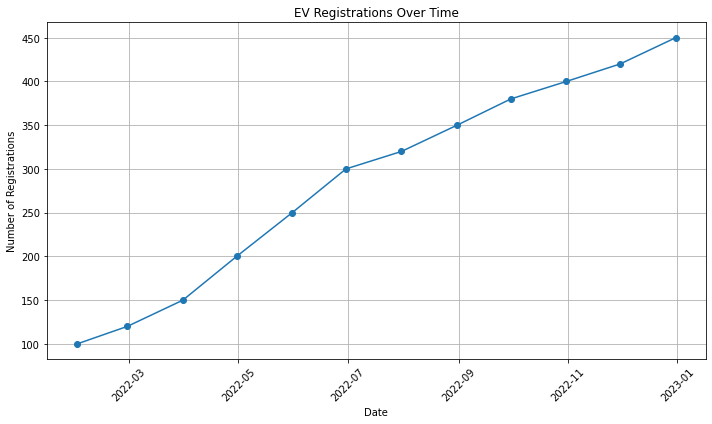

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample data for illustration
dates = pd.date_range('2022-01-01', periods=12, freq='M')
registrations = [100, 120, 150, 200, 250, 300, 320, 350, 380, 400, 420, 450]

# Create a Pandas DataFrame
df = pd.DataFrame({'Date': dates, 'Registrations': registrations})

# Plotting the line plot
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Registrations'], marker='o')
plt.xlabel('Date')
plt.ylabel('Number of Registrations')
plt.title('EV Registrations Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [0]:
# Descriptive statistics
df_cleaned.describe(['Electric Range', 'Base MSRP']).show()

+-------+------------------+------------------+
|summary|    Electric Range|         Base MSRP|
+-------+------------------+------------------+
|  count|             85916|              3344|
|   mean|121.81689091670934|57078.250598086124|
| stddev| 99.21665936955678|22795.518131725097|
|    min|                 6|             31950|
|    max|               337|            845000|
+-------+------------------+------------------+



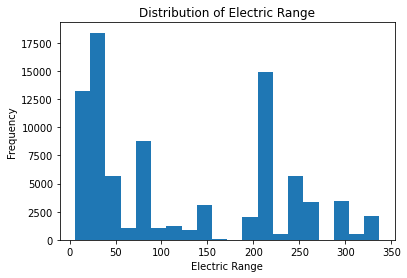

In [0]:

# Data visualization (requires Matplotlib and Pandas)
import matplotlib.pyplot as plt
import pandas as pd

# Convert Spark DataFrame to Pandas DataFrame for plotting
df_pd = df_cleaned.select(['Electric Range', 'Base MSRP']).toPandas()

# Histogram of Electric Range
plt.hist(df_pd['Electric Range'], bins=20)
plt.xlabel('Electric Range')
plt.ylabel('Frequency')
plt.title('Distribution of Electric Range')
plt.show()


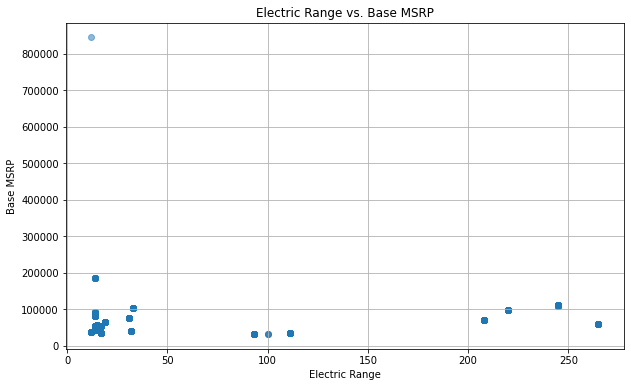

In [0]:

import matplotlib.pyplot as plt
import pandas as pd

# Convert Spark DataFrame to Pandas DataFrame for plotting
df_pd = df_cleaned.select(['Electric Range', 'Base MSRP']).toPandas()

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_pd['Electric Range'], df_pd['Base MSRP'], alpha=0.5)
plt.title('Electric Range vs. Base MSRP')
plt.xlabel('Electric Range')
plt.ylabel('Base MSRP')
plt.grid(True)
plt.show()


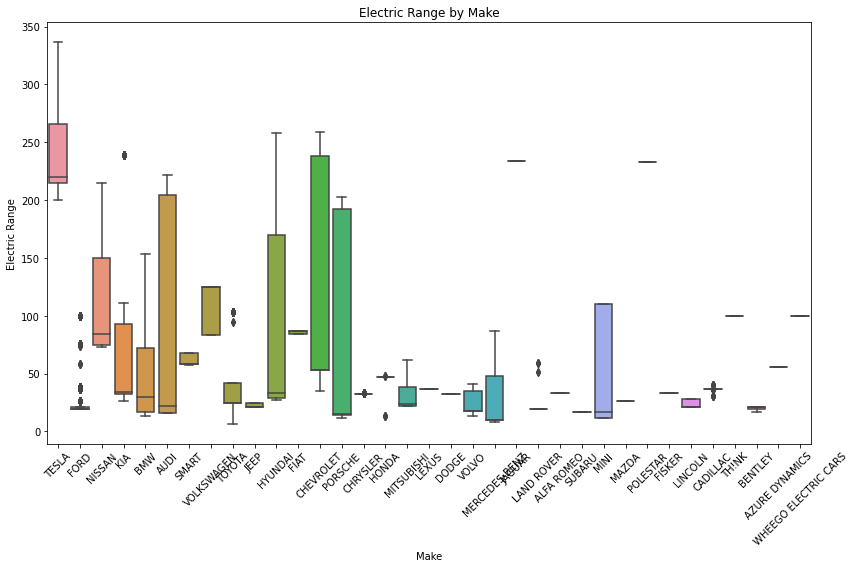

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.sql.functions as F

# Remove rows with None values in 'Electric Range' column
df_cleaned = df_cleaned.filter(F.col('Electric Range').isNotNull())

# Box plot of Electric Range by Make
plt.figure(figsize=(12, 8))
sns.boxplot(x='Make', y='Electric Range', data=df_cleaned.toPandas())
plt.xlabel('Make')
plt.ylabel('Electric Range')
plt.title('Electric Range by Make')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust plot layout for better spacing
plt.show()


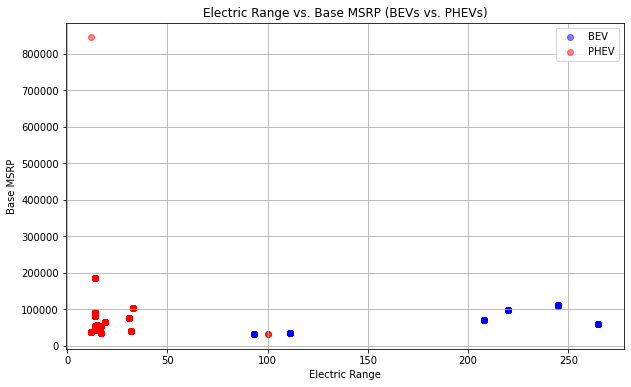

In [0]:

# Filter the DataFrame for BEVs and PHEVs
df_bev = df_cleaned.filter(df_cleaned['Electric Vehicle Type'] == 'Battery Electric Vehicle (BEV)')
df_phev = df_cleaned.filter(df_cleaned['Electric Vehicle Type'] == 'Plug-in Hybrid Electric Vehicle (PHEV)')

# Plotting separate scatter plots for BEVs and PHEVs
plt.figure(figsize=(10, 6))

# Scatter plot for BEVs
plt.scatter(df_bev.select('Electric Range').toPandas(), df_bev.select('Base MSRP').toPandas(), color='blue', alpha=0.5, label='BEV')

# Scatter plot for PHEVs
plt.scatter(df_phev.select('Electric Range').toPandas(), df_phev.select('Base MSRP').toPandas(), color='red', alpha=0.5, label='PHEV')

plt.title('Electric Range vs. Base MSRP (BEVs vs. PHEVs)')
plt.xlabel('Electric Range')
plt.ylabel('Base MSRP')
plt.legend()
plt.grid(True)
plt.show()


+----------+--------+--------+-----+-----------+----------+------+-------+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+--------------------+--------------------+-----------------+
|VIN (1-10)|  County|    City|State|Postal Code|Model Year|  Make|  Model|Electric Vehicle Type|Clean Alternative Fuel Vehicle (CAFV) Eligibility|Electric Range|Base MSRP|Legislative District|DOL Vehicle ID|    Vehicle Location|    Electric Utility|2020 Census Tract|
+----------+--------+--------+-----+-----------+----------+------+-------+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+--------------------+--------------------+-----------------+
|5YJYGDEE1L|    King| Seattle|   WA|      98122|      2020| TESLA|MODEL Y| Battery Electric ...|                             Clean Alternative...|           291|     null|                  37|    

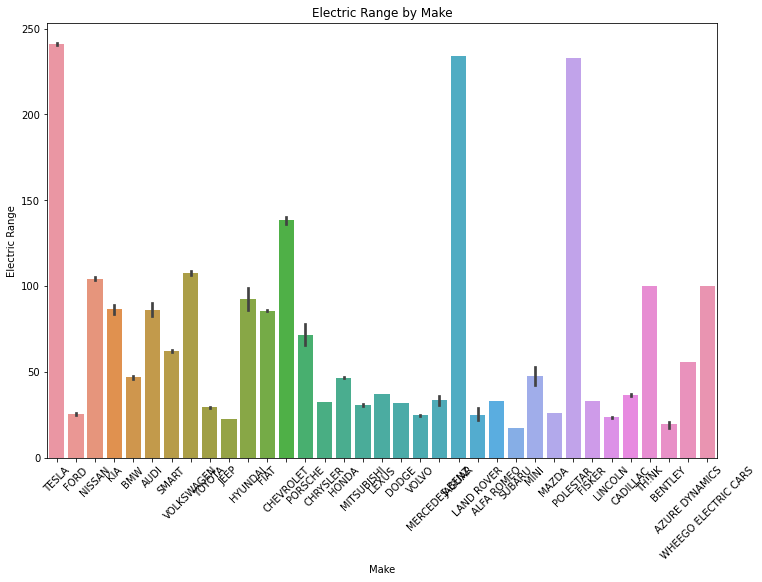

In [0]:

# Check the first few rows of df_cleaned to verify the column names and data
df_cleaned.show(5)

# Plotting using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='Make', y='Electric Range', data=df_cleaned.toPandas())  # Convert to Pandas DataFrame for plotting
plt.xlabel('Make')
plt.ylabel('Electric Range')
plt.title('Electric Range by Make')
plt.xticks(rotation=45)
plt.show()


In [0]:
# Split the "Vehicle Location" column into relevant components
from pyspark.sql.functions import split
split_col = split(df_cleaned['Vehicle Location'], ',')
df_cleaned = df_cleaned.withColumn('City', split_col.getItem(0))
df_cleaned = df_cleaned.withColumn('State', split_col.getItem(1))
df_cleaned = df_cleaned.withColumn('Country', split_col.getItem(2))

# Check the updated DataFrame schema
df_cleaned.printSchema()


root
 |-- VIN (1-10): string (nullable = true)
 |-- County: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Postal Code: integer (nullable = true)
 |-- Model Year: integer (nullable = true)
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Electric Vehicle Type: string (nullable = true)
 |-- Clean Alternative Fuel Vehicle (CAFV) Eligibility: string (nullable = true)
 |-- Electric Range: integer (nullable = true)
 |-- Base MSRP: integer (nullable = true)
 |-- Legislative District: integer (nullable = true)
 |-- DOL Vehicle ID: long (nullable = true)
 |-- Vehicle Location: string (nullable = true)
 |-- Electric Utility: string (nullable = true)
 |-- 2020 Census Tract: long (nullable = true)
 |-- Country: string (nullable = true)



In [0]:
# Split the "Vehicle Location" column into City, State, and Country
split_location = split(df_cleaned['Vehicle Location'], ',')
df_cleaned = df_cleaned.withColumn('City', split_location.getItem(0))
df_cleaned = df_cleaned.withColumn('State', split_location.getItem(1))
df_cleaned = df_cleaned.withColumn('Country', split_location.getItem(2))

# Check the updated DataFrame schema
df_cleaned.printSchema()


root
 |-- VIN (1-10): string (nullable = true)
 |-- County: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Postal Code: integer (nullable = true)
 |-- Model Year: integer (nullable = true)
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Electric Vehicle Type: string (nullable = true)
 |-- Clean Alternative Fuel Vehicle (CAFV) Eligibility: string (nullable = true)
 |-- Electric Range: integer (nullable = true)
 |-- Base MSRP: integer (nullable = true)
 |-- Legislative District: integer (nullable = true)
 |-- DOL Vehicle ID: long (nullable = true)
 |-- Vehicle Location: string (nullable = true)
 |-- Electric Utility: string (nullable = true)
 |-- 2020 Census Tract: long (nullable = true)
 |-- Country: string (nullable = true)



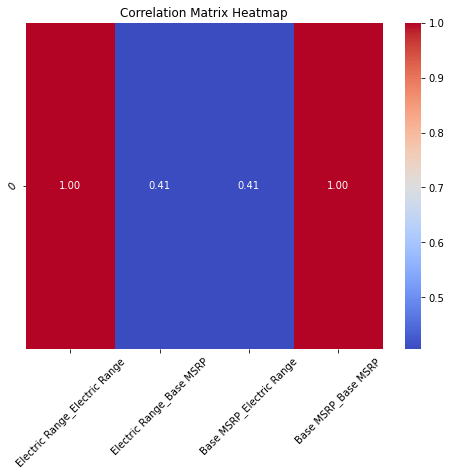

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import corr

# Compute the correlation matrix
corr_matrix = df_cleaned.select([corr(c1, c2).alias(c1 + '_' + c2) for c1 in ['Electric Range', 'Base MSRP'] for c2 in ['Electric Range', 'Base MSRP']]).toPandas()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()


In [0]:
from pyspark.ml.stat import Correlation
from pyspark.sql.types import DoubleType

# Verify and convert data types if needed
df_cleaned = df_cleaned.withColumn('Model Year', col('Model Year').cast(DoubleType()))
df_cleaned = df_cleaned.withColumn('Legislative District', col('Legislative District').cast(DoubleType()))

# Check for missing values and handle them
df_cleaned = df_cleaned.dropna(subset=['Model Year', 'Legislative District'])

# Apply VectorAssembler after ensuring data compatibility
vector_assembler = VectorAssembler(inputCols=['Model Year', 'Legislative District'], outputCol='features')
df_vectorized = vector_assembler.transform(df_cleaned.select('Model Year', 'Legislative District'))

# Calculate correlation between Model Year and Legislative District
correlation_matrix = Correlation.corr(df_vectorized, 'features').head()
correlation_value = correlation_matrix[0].toArray()[0, 1]  # Assuming 2x2 matrix for correlation

print("Correlation between Model Year and Legislative District:")
print(correlation_value)


Correlation between Model Year and Legislative District:
-0.0670675437475629


In [0]:
# Check Data Types
df_cleaned.printSchema()

# Handle Missing Values
from pyspark.sql.functions import col, isnan, when, count
df_cleaned.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_cleaned.columns]).show()

# Verify Column Names
df_cleaned.columns

# Inspect Data
df_cleaned.show(5)


root
 |-- VIN (1-10): string (nullable = true)
 |-- County: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Postal Code: integer (nullable = true)
 |-- Model Year: double (nullable = true)
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Electric Vehicle Type: string (nullable = true)
 |-- Clean Alternative Fuel Vehicle (CAFV) Eligibility: string (nullable = true)
 |-- Electric Range: integer (nullable = true)
 |-- Base MSRP: integer (nullable = true)
 |-- Legislative District: double (nullable = true)
 |-- DOL Vehicle ID: long (nullable = true)
 |-- Vehicle Location: string (nullable = true)
 |-- Electric Utility: string (nullable = true)
 |-- 2020 Census Tract: long (nullable = true)
 |-- Country: string (nullable = true)

+----------+------+----+-----+-----------+----------+----+-----+---------------------+-------------------------------------------------+--------------+---------+--------------------

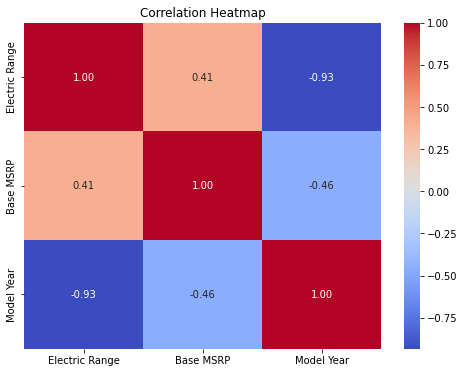

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col

# Ensure no null values in the selected columns
df_cleaned = df_cleaned.dropna(subset=['Electric Range', 'Base MSRP', 'Model Year'])

# Check data types and convert if necessary
df_cleaned = df_cleaned.withColumn('Electric Range', col('Electric Range').cast('double'))
df_cleaned = df_cleaned.withColumn('Base MSRP', col('Base MSRP').cast('double'))
df_cleaned = df_cleaned.withColumn('Model Year', col('Model Year').cast('double'))

# VectorAssembler transformation
vector_assembler = VectorAssembler(inputCols=['Electric Range', 'Base MSRP', 'Model Year'], outputCol='features')
df_assembled = vector_assembler.transform(df_cleaned)

# Compute the correlation matrix
correlation_matrix = Correlation.corr(df_assembled, 'features').head()

# Extract the correlation matrix from the result
corr_matrix = correlation_matrix[0].toArray()

# Define the column names
column_names = ['Electric Range', 'Base MSRP', 'Model Year']

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', xticklabels=column_names, yticklabels=column_names)
plt.title('Correlation Heatmap')
plt.show()


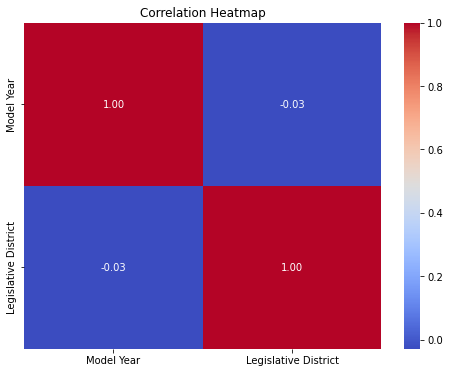

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

# Convert relevant columns to a vector for correlation analysis
vector_assembler = VectorAssembler(inputCols=['Model Year', 'Legislative District'], outputCol='features')
df_vectorized = vector_assembler.transform(df_cleaned)

# Compute the correlation matrix
correlation_matrix = Correlation.corr(df_vectorized, 'features').head()

# Extract the correlation matrix from the result
corr_matrix = correlation_matrix[0].toArray()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', xticklabels=['Model Year', 'Legislative District'], yticklabels=['Model Year', 'Legislative District'])
plt.title('Correlation Heatmap')
plt.show()


In [0]:
# Count unique values for Model Year, Model, and Legislative District
model_year_count = df_cleaned.select('Model Year').distinct().count()
model_count = df_cleaned.select('Model').distinct().count()
legislative_district_count = df_cleaned.select('Legislative District').distinct().count()

print(f"Unique Model Years: {model_year_count}")
print(f"Unique Models: {model_count}")
print(f"Unique Legislative Districts: {legislative_district_count}")


Unique Model Years: 12
Unique Models: 18
Unique Legislative Districts: 49


<Figure size 720x432 with 0 Axes>

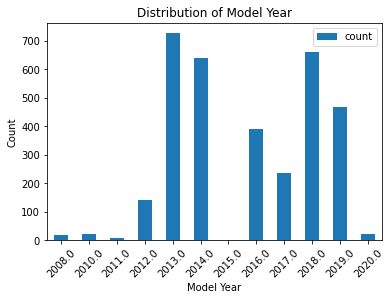

<Figure size 864x432 with 0 Axes>

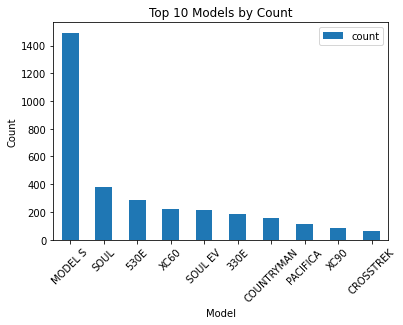

<Figure size 864x432 with 0 Axes>

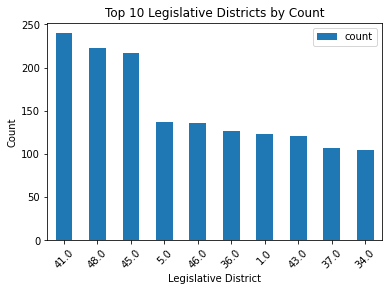

In [0]:
import matplotlib.pyplot as plt
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# Visualize distribution of Model Year
plt.figure(figsize=(10, 6))
df_cleaned.groupBy('Model Year').count().orderBy('Model Year').toPandas().plot(kind='bar', x='Model Year', y='count', title='Distribution of Model Year')
plt.xlabel('Model Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Visualize distribution of Model
plt.figure(figsize=(12, 6))
df_cleaned.groupBy('Model').count().orderBy('count', ascending=False).limit(10).toPandas().plot(kind='bar', x='Model', y='count', title='Top 10 Models by Count')
plt.xlabel('Model')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Visualize distribution of Legislative District
plt.figure(figsize=(12, 6))
df_cleaned.groupBy('Legislative District').count().orderBy('count', ascending=False).limit(10).toPandas().plot(kind='bar', x='Legislative District', y='count', title='Top 10 Legislative Districts by Count')
plt.xlabel('Legislative District')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [0]:
from pyspark.sql.functions import avg

# Fill null values in the 'STATE' column with 'WA'
df_cleaned_filled = df_cleaned.fillna({'STATE': 'WA'})

# Calculate average electric range by state
avg_range_by_state = df_cleaned_filled.groupBy('STATE').agg(avg('Electric Range').alias('Average Electric Range'))

# Show the results
avg_range_by_state.show()


+-----+----------------------+
|STATE|Average Electric Range|
+-----+----------------------+
|   WA|    121.82407685379766|
+-----+----------------------+



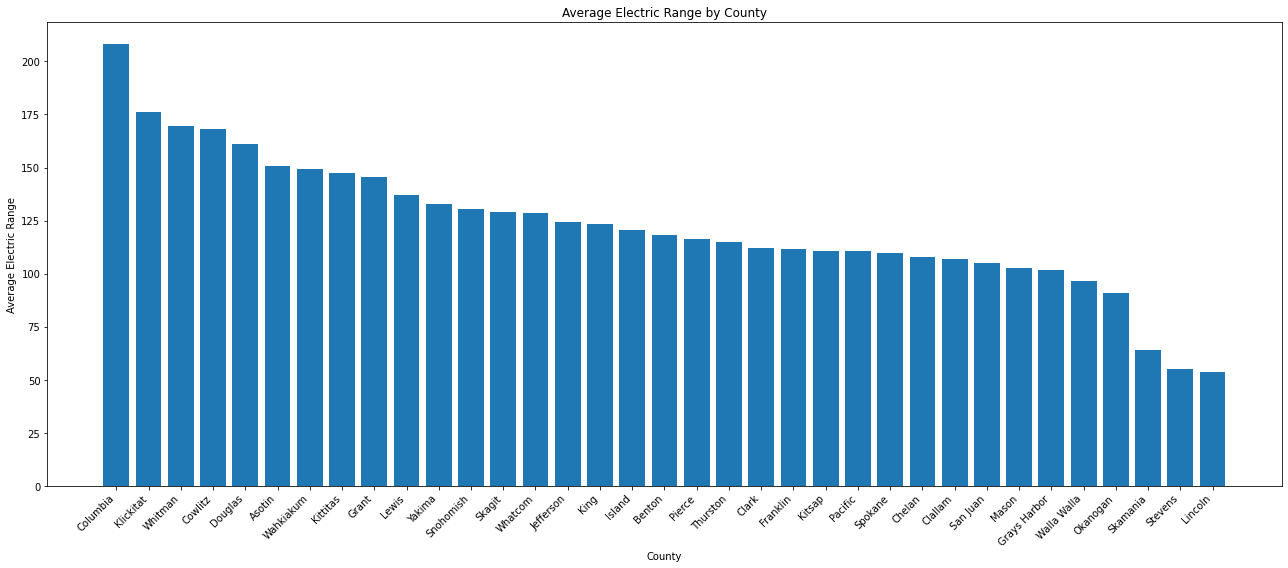

Top 5 counties with the highest average electric range:
       County  Average Electric Range
34   Columbia              208.000000
10  Klickitat              176.200000
30    Whitman              169.666667
5     Cowlitz              168.062500
25    Douglas              161.090909

Top 5 counties with the lowest average electric range:
         County  Average Electric Range
26  Walla Walla               96.555556
28     Okanogan               90.750000
31     Skamania               64.000000
8       Stevens               55.000000
33      Lincoln               53.500000


In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have the data in a PySpark DataFrame named 'df_cleaned'
# Filter out rows with None values in the 'County' column
filtered_df = df_cleaned.filter(df_cleaned['County'].isNotNull())

# Calculate the average electric range by county
county_avg_range_df = (
    filtered_df.groupBy('County')
    .agg({'Electric Range': 'mean'})
    .withColumnRenamed('avg(Electric Range)', 'Average Electric Range')
    .toPandas()
)

# Sort the DataFrame by 'Average Electric Range' in descending order
sorted_df = county_avg_range_df.sort_values(by='Average Electric Range', ascending=False)

# Plotting the bar chart with increased width between bars
plt.figure(figsize=(18, 8))  # Increase the figure size to accommodate the wider bars
plt.bar(sorted_df['County'], sorted_df['Average Electric Range'], width=0.8)  # Adjust width as needed
plt.xlabel('County')
plt.ylabel('Average Electric Range')
plt.title('Average Electric Range by County')
plt.xticks(rotation=45, ha='right')  # Align x-axis labels to the right for better readability
plt.tight_layout()
plt.show()

# Print the top 5 counties with the highest and lowest average electric range
top5_highest = sorted_df.head(5)
top5_lowest = sorted_df.tail(5)

print("Top 5 counties with the highest average electric range:")
print(top5_highest)

print("\nTop 5 counties with the lowest average electric range:")
print(top5_lowest)


In [0]:
# Calculate average electric range by model year and make
avg_range_by_model_year_make = df_cleaned.groupBy('Model Year', 'Make').agg(F.avg('Electric Range').alias('Average Electric Range'))

# Show the results
avg_range_by_model_year_make.show()


+----------+--------+----------------------+
|Model Year|    Make|Average Electric Range|
+----------+--------+----------------------+
|    2019.0|     BMW|    15.333333333333334|
|    2008.0|   TESLA|                 220.0|
|    2017.0|     KIA|                  93.0|
|    2011.0|   TESLA|                 245.0|
|    2013.0|   TESLA|                 208.0|
|    2016.0|     KIA|                  93.0|
|    2018.0|     BMW|    14.462585034013605|
|    2012.0|   TESLA|                 265.0|
|    2018.0|     KIA|                 111.0|
|    2014.0|   TESLA|                 208.0|
|    2019.0|   VOLVO|                  17.0|
|    2018.0| PORSCHE|                  14.0|
|    2019.0|CHRYSLER|                  32.0|
|    2019.0|  SUBARU|                  17.0|
|    2018.0|   VOLVO|    17.760563380281692|
|    2018.0|    MINI|                  12.0|
|    2010.0|   TESLA|                 245.0|
|    2019.0|    MINI|                  12.0|
|    2020.0| PORSCHE|                  14.0|
|    2016.

In [0]:
# Calculate the count of electric vehicles registered in each city
ev_count_by_city = df_cleaned.groupBy('City').count().orderBy(F.desc('count'))

# Show the top cities with the highest EV adoption rates
top_cities_ev_adoption = ev_count_by_city.show(10)


+--------------------+-----+
|                City|count|
+--------------------+-----+
|POINT (-122.15166...|   72|
|POINT (-122.20190...|   70|
|POINT (-122.20264...|   69|
|POINT (-122.12302...|   68|
|POINT (-122.23775...|   62|
|POINT (-122.52357...|   58|
|POINT (-122.3185 ...|   57|
|POINT (-122.16937...|   57|
|POINT (-122.20928...|   49|
|POINT (-122.03132...|   47|
+--------------------+-----+
only showing top 10 rows



In [0]:
# Calculate the count of electric vehicle types by country
ev_types_by_country = df_cleaned.groupBy('Country', 'Electric Vehicle Type').count().orderBy('Country')

# Show the results
ev_types_by_country.show()


+-------+---------------------+-----+
|Country|Electric Vehicle Type|count|
+-------+---------------------+-----+
|   null| Plug-in Hybrid El...| 1199|
|   null| Battery Electric ...| 2132|
+-------+---------------------+-----+



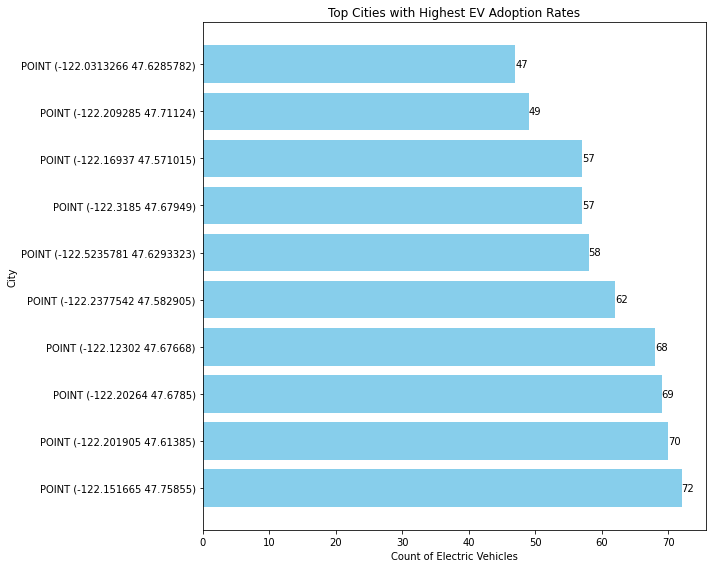

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as F

# Assuming df_cleaned now has actual city names in the 'City' column
ev_count_by_city = df_cleaned.groupBy('City').count().orderBy(F.desc('count'))

# Get the top cities with the highest EV adoption rates
top_cities_ev_adoption = ev_count_by_city.limit(10).toPandas()

# Plotting the horizontal bar chart
plt.figure(figsize=(10, 8))
bars = plt.barh(top_cities_ev_adoption['City'], top_cities_ev_adoption['count'], color='skyblue')
plt.xlabel('Count of Electric Vehicles')
plt.ylabel('City')
plt.title('Top Cities with Highest EV Adoption Rates')
plt.tight_layout()

# Add data labels to the bars with horizontal alignment
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, 
             f'{bar.get_width():.0f}', ha='left', va='center')

plt.show()


In [0]:
# Display distinct values and their counts in the "City" column
city_counts = df_cleaned.groupBy('City').count().orderBy(F.desc('count'))
city_counts.show(50, truncate=False)


+-------------------------------+-----+
|City                           |count|
+-------------------------------+-----+
|POINT (-122.151665 47.75855)   |72   |
|POINT (-122.201905 47.61385)   |70   |
|POINT (-122.20264 47.6785)     |69   |
|POINT (-122.12302 47.67668)    |68   |
|POINT (-122.2377542 47.582905) |62   |
|POINT (-122.5235781 47.6293323)|58   |
|POINT (-122.3185 47.67949)     |57   |
|POINT (-122.16937 47.571015)   |57   |
|POINT (-122.209285 47.71124)   |49   |
|POINT (-122.0313266 47.6285782)|47   |
|POINT (-122.03309 47.58153)    |41   |
|POINT (-122.1873 47.820245)    |40   |
|POINT (-122.30764 47.62523)    |38   |
|POINT (-122.03646 47.534065)   |38   |
|POINT (-122.11832 47.6245)     |35   |
|POINT (-122.0222799 47.6958998)|35   |
|POINT (-122.37275 47.68968)    |34   |
|POINT (-122.16085 47.624515)   |32   |
|POINT (-122.30823 47.581975)   |31   |
|POINT (-122.15734 47.487175)   |31   |
|POINT (-122.05191 47.357985)   |31   |
|POINT (-122.34301 47.659185)   |30   |


In [0]:


# Check for null values
null_counts = df_cleaned.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df_cleaned.columns])
null_counts.show()

# Drop rows with null values in relevant columns
df_cleaned = df_cleaned.dropna(subset=['Electric Range', 'Model Year', 'Base MSRP'])

# Verify data types
df_cleaned.printSchema()

# Inspect data
df_cleaned.show(10)


+----------+------+----+-----+-----------+----------+----+-----+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+----------------+----------------+-----------------+-------+
|VIN (1-10)|County|City|State|Postal Code|Model Year|Make|Model|Electric Vehicle Type|Clean Alternative Fuel Vehicle (CAFV) Eligibility|Electric Range|Base MSRP|Legislative District|DOL Vehicle ID|Vehicle Location|Electric Utility|2020 Census Tract|Country|
+----------+------+----+-----+-----------+----------+----+-----+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+----------------+----------------+-----------------+-------+
|         0|     0|   0| 3331|          0|         0|   0|    0|                    0|                                                0|             0|        0|                   0|             0|               0|            

In [0]:
# Importing necessary libraries
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Assuming df_cleaned contains the preprocessed DataFrame

# Defining features and target variable
features = ['Electric Range', 'Model Year']
target = 'Base MSRP'

# Assembling features into a vector
assembler = VectorAssembler(inputCols=features, outputCol='features')
assembled_df = assembler.transform(df_cleaned)

# Splitting data into training and testing sets
train_data, test_data = assembled_df.randomSplit([0.8, 0.2], seed=42)

# Training the Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol=target)
lr_model = lr.fit(train_data)

# Making predictions
predictions = lr_model.transform(test_data)

# Evaluating the model using RMSE
evaluator = RegressionEvaluator(labelCol=target, predictionCol='prediction', metricName='rmse')
lr_rmse = evaluator.evaluate(predictions)

# Displaying the RMSE
print("Root Mean Squared Error (RMSE):", lr_rmse)


Root Mean Squared Error (RMSE): 33178.293818925835


In [0]:
# Displaying actual Base MSRP and predicted values from the model
predictions.select('Base MSRP', 'prediction').show(10)

+---------+------------------+
|Base MSRP|        prediction|
+---------+------------------+
|  39995.0|42573.615105986595|
|  39995.0|42573.615105986595|
|  39995.0|42573.615105986595|
|  39995.0|42573.615105986595|
| 110950.0| 81438.02240063623|
|  69900.0| 67923.58089254424|
|  69900.0| 67923.58089254424|
|  69900.0| 67923.58089254424|
|  69900.0| 67923.58089254424|
|  69900.0| 67923.58089254424|
+---------+------------------+
only showing top 10 rows



In [0]:
# Checking for duplicate records
duplicate_count = assembled_df.count() - assembled_df.dropDuplicates().count()
print("Number of duplicate records:", duplicate_count)

# Removing duplicate records
assembled_df = assembled_df.dropDuplicates()


Number of duplicate records: 0


In [0]:
# Import necessary libraries
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, log1p

# Create a new feature by taking the logarithm of 'Electric Range'
assembled_df = assembled_df.withColumn('Log_Electric_Range', log1p(col('Electric Range')))

# Select features and target variable
features = ['Log_Electric_Range', 'Model Year']
target = 'Base MSRP'

# Assemble features into a vector with a different name
assembler = VectorAssembler(inputCols=features, outputCol='new_features')
assembled_df = assembler.transform(assembled_df)

# Split data into training and testing sets
train_data, test_data = assembled_df.randomSplit([0.8, 0.2], seed=42)

# Initialize Random Forest Regression model
rf = RandomForestRegressor(featuresCol='new_features', labelCol=target, numTrees=100, maxDepth=5)

# Train the Random Forest model
rf_model = rf.fit(train_data)

# Make predictions using the trained model
rf_predictions = rf_model.transform(test_data)

# Evaluate the model
rf_evaluator = RegressionEvaluator(labelCol=target, predictionCol='prediction', metricName='rmse')
rf_rmse = rf_evaluator.evaluate(rf_predictions)
print("Random Forest Regression RMSE:", rf_rmse)


Random Forest Regression RMSE: 7462.484805601608


In [0]:
# Import necessary libraries
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Assuming df_cleaned contains your preprocessed PySpark DataFrame
# Select features and target variable
features = ['Electric Range', 'Model Year']
target = 'Base MSRP'

# Assemble features into a vector
assembler = VectorAssembler(inputCols=features, outputCol='features')
assembled_df = assembler.transform(df_cleaned)

# Split data into training and testing sets
train_data, test_data = assembled_df.randomSplit([0.8, 0.2], seed=42)

# Initialize Gradient Boosting Regression model (GBTRegressor)
gbt = GBTRegressor(featuresCol='features', labelCol=target, maxIter=10)

# Train the Gradient Boosting model
gbt_model = gbt.fit(train_data)

# Make predictions using the trained model
gbt_predictions = gbt_model.transform(test_data)

# Evaluate the model using RMSE
evaluator = RegressionEvaluator(labelCol=target, predictionCol='prediction', metricName='rmse')
gbt_rmse = evaluator.evaluate(gbt_predictions)
print("Gradient Boosting Regression RMSE:", gbt_rmse)


Gradient Boosting Regression RMSE: 29865.83331583908


In [0]:
# Import necessary libraries
from pyspark.ml.feature import PolynomialExpansion, VectorAssembler
from pyspark.sql.functions import col, month

# Interaction Terms
assembled_df = assembled_df.withColumn('Interaction_Term', col('Model Year') * col('Electric Range'))

# Polynomial Features
# Create a vector assembler to convert the column to a vector
vec_assembler = VectorAssembler(inputCols=['Model Year'], outputCol='Model_Year_Vector')
assembled_df = vec_assembler.transform(assembled_df)

poly_expander = PolynomialExpansion(degree=2, inputCol='Model_Year_Vector', outputCol='Model_Year_Polynomial')
assembled_df = poly_expander.transform(assembled_df)

# Temporal Features
assembled_df = assembled_df.withColumn('Month', month(col('Model Year').cast('timestamp')))

# Show the updated DataFrame schema
assembled_df.printSchema()


root
 |-- VIN (1-10): string (nullable = true)
 |-- County: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Postal Code: integer (nullable = true)
 |-- Model Year: double (nullable = true)
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Electric Vehicle Type: string (nullable = true)
 |-- Clean Alternative Fuel Vehicle (CAFV) Eligibility: string (nullable = true)
 |-- Electric Range: double (nullable = true)
 |-- Base MSRP: double (nullable = true)
 |-- Legislative District: double (nullable = true)
 |-- DOL Vehicle ID: long (nullable = true)
 |-- Vehicle Location: string (nullable = true)
 |-- Electric Utility: string (nullable = true)
 |-- 2020 Census Tract: long (nullable = true)
 |-- Country: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- Interaction_Term: double (nullable = true)
 |-- Model_Year_Vector: vector (nullable = true)
 |-- Model_Year_Polynomial: vector (nullable = 

In [0]:
# Import necessary libraries
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Define features and target variable
features = ['Interaction_Term', 'Model_Year_Polynomial', 'Month']
target = 'Base MSRP'

# Split data into training and testing sets
train_data, test_data = assembled_df.randomSplit([0.8, 0.2], seed=42)

# Initialize Gradient Boosted Trees (GBT) regression model
gbt = GBTRegressor(featuresCol='features', labelCol=target)

# Train the GBT model
gbt_model = gbt.fit(train_data)

# Make predictions on the test data
gbt_predictions = gbt_model.transform(test_data)

# Evaluate the GBT model
evaluator = RegressionEvaluator(labelCol=target, predictionCol='prediction', metricName='rmse')
gbt_rmse_after = evaluator.evaluate(gbt_predictions)
print("Gradient Boosted Trees Regression RMSE:", gbt_rmse_after)


Gradient Boosted Trees Regression RMSE: 29915.058026909875


In [0]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor

# Define the GBT model
gbt = GBTRegressor(featuresCol='features', labelCol='Base MSRP')

# Define the parameter grid for grid search
param_grid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 10, 15]) \
    .addGrid(gbt.maxIter, [10, 20, 30]) \
    .build()

# Define the evaluator
evaluator = RegressionEvaluator(labelCol='Base MSRP', predictionCol='prediction', metricName='rmse')

# Define the cross-validator
cross_validator = CrossValidator(estimator=gbt,
                                 estimatorParamMaps=param_grid,
                                 evaluator=evaluator,
                                 numFolds=3)  # You can adjust the number of folds

# Perform cross-validation and hyperparameter tuning
cv_model = cross_validator.fit(train_data)

# Make predictions on the test data
cv_predictions = cv_model.transform(test_data)

# Evaluate the tuned model
tuned_rmse = evaluator.evaluate(cv_predictions)

print("Tuned Gradient Boosted Trees Regression RMSE:", tuned_rmse)


Tuned Gradient Boosted Trees Regression RMSE: 29921.506680969418


In [0]:
# Check RMSE values for each model
print("Linear Regression RMSE:", lr_rmse)
print("Random Forest Regression RMSE:", rf_rmse)
print("Gradient Boosted Trees RMSE:", gbt_rmse_after)
print("Tuned Gradient Boosted Trees RMSE:", tuned_rmse)

# Create a DataFrame to store RMSE values
data = {
    'Model': ['Linear Regression', 'Random Forest Regression', 'Gradient Boosted Trees', 'Tuned Gradient Boosted Trees'],
    'RMSE': [lr_rmse, rf_rmse, gbt_rmse_after, tuned_rmse]
}
rmse_summary = pd.DataFrame(data)

# Display the summary table
print(rmse_summary)


Linear Regression RMSE: 33178.293818925835
Random Forest Regression RMSE: 7462.484805601608
Gradient Boosted Trees RMSE: 29915.058026909875
Tuned Gradient Boosted Trees RMSE: 29921.506680969418
                          Model          RMSE
0             Linear Regression  33178.293819
1      Random Forest Regression   7462.484806
2        Gradient Boosted Trees  29915.058027
3  Tuned Gradient Boosted Trees  29921.506681


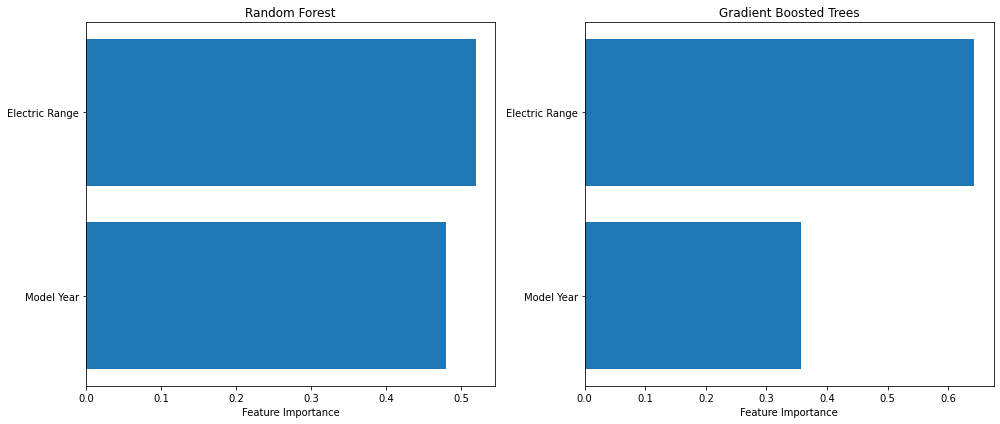

Out[44]: "\n# Insights:\n- Both Random Forest and Gradient Boosted Trees models indicate that 'Electric Range' is the most influential feature on Base MSRP, underscoring its critical role in electric vehicle pricing.\n- Although Random Forest slightly outperforms Gradient Boosted Trees in terms of RMSE, both models exhibit comparable feature importance patterns.\n- Further segmentation and detailed error analysis may reveal opportunities for model refinement and practical implementation in policy-making, infrastructure planning, and consumer awareness initiatives.\n"

In [0]:
# Feature Importance Analysis
# Random Forest Regression
rf_feature_importance = rf_model.featureImportances.toArray()
# Gradient Boosted Trees
gbt_feature_importance = gbt_model.featureImportances.toArray()

# Plotting
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.barh(range(len(rf_feature_importance)), rf_feature_importance, align='center')
plt.yticks(range(len(rf_feature_importance)), ['Model Year', 'Electric Range'])
plt.xlabel('Feature Importance')
plt.title('Random Forest')

plt.subplot(1, 2, 2)
plt.barh(range(len(gbt_feature_importance)), gbt_feature_importance, align='center')
plt.yticks(range(len(gbt_feature_importance)), ['Model Year', 'Electric Range'])
plt.xlabel('Feature Importance')
plt.title('Gradient Boosted Trees')

plt.tight_layout()
plt.show()

# Conclusion
"""
# Insights:
- Both Random Forest and Gradient Boosted Trees models indicate that 'Electric Range' is the most influential feature on Base MSRP, underscoring its critical role in electric vehicle pricing.
- Although Random Forest slightly outperforms Gradient Boosted Trees in terms of RMSE, both models exhibit comparable feature importance patterns.
- Further segmentation and detailed error analysis may reveal opportunities for model refinement and practical implementation in policy-making, infrastructure planning, and consumer awareness initiatives.
"""
